# Лабораторная работа №2

Бирюков В. В.

Группа: М8О-407Б-19

In [ ]:
# в google colab старая версия matplotlib
!pip install --upgrade matplotlib

In [1]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from collections import defaultdict
import logging
import pandas as pd

In [3]:
import torch, torchvision
from torch.utils.data.dataloader import DataLoader
import cv2
from torchvision.datasets import VOCSegmentation
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, RandomSizedCrop, OneOf, PadIfNeeded, CenterCrop, GridDistortion, ElasticTransform, OpticalDistortion
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [4]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(filename='train_log.csv', filemode='a', format='%(asctime)s,%(message)s', datefmt='%d-%m-%y %H:%M:%S', level=logging.INFO)

## Датасет

In [5]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

In [6]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORS = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

VOC_COLORMAP = ListedColormap(np.array(VOC_COLORS) / 255)

In [7]:
class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORS)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORS):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask

In [8]:
def plot_image(img, mask, net = None):
    fig, axes = plt.subplots(1, 2 + (net is not None), figsize=(4 * (2 + (net is not None)), 4))
    axes[0].imshow(img.permute(1, 2, 0))
    if net is not None:
        axes[1].imshow(net(img.expand(1, -1, -1, -1).cuda())['out'].cpu()[0].softmax(0).argmax(0), vmin=0, vmax=len(VOC_CLASSES), cmap=VOC_COLORMAP, interpolation='nearest')
    axes[1 + (net is not None)].imshow(mask.argmax(0), vmin=0, vmax=len(VOC_CLASSES), cmap=VOC_COLORMAP, interpolation='nearest')
    
    for ax in axes:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    return fig

In [9]:
train_augs = Compose([
    PadIfNeeded(448, 448),
    RandomBrightnessContrast(),
    OneOf([
        GridDistortion(),
        ElasticTransform()
    ]),
    OneOf([
        RandomCrop(256, 256, p=0.3),
        RandomSizedCrop((224, 448), 256, 256)
    ], p=1),
])

train_dataset = PascalVOCSearchDataset('.', download=True, transform=train_augs)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./VOCtrainval_11-May-2012.tar to .


In [10]:
val_augs = Compose([
    PadIfNeeded(448, 448),
    CenterCrop(448, 448)
])

val_dataset = PascalVOCSearchDataset('.', image_set='val', download=True, transform=val_augs)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


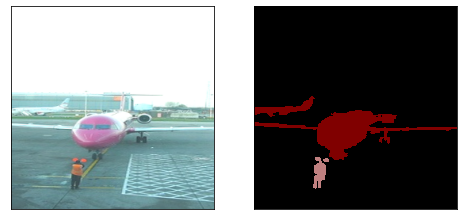

In [11]:
plot_image(*train_dataset[0])
plt.show()

## Метрики

In [12]:
def IoU(predict, mask):
    predict = predict.softmax(1)
    predict = predict.argmax(1)
    predict = torch.nn.functional.one_hot(predict, len(VOC_CLASSES))
    predict = torch.permute(predict, (0, 3, 1, 2))
    predict = predict.to(int)
    mask = mask.to(int)

    with torch.no_grad():
        intersection = (predict & mask).sum([2, 3])
        union = (predict | mask).sum([2, 3])
    return intersection / (union + 1e-6)

def MIoU(predict, mask):
    iou = IoU(predict, mask)
    return iou.sum(1) / mask.sum([2, 3]).count_nonzero(1)

## Функции обучение и тестирование

In [13]:
def fit(net, train, val, epochs, crit, optimizer, **optim_args):
    history = defaultdict(list)
    optim = optimizer(net.parameters(), **optim_args)
    for epoch in range(epochs):
        rloss = 0
        for img, mask in train:
            img = img.cuda()
            mask = mask.cuda()
            predict = net(img)['out']
            loss = crit(predict, mask)
            optim.zero_grad()
            loss.backward()
            optim.step()
            rloss += loss.detach().cpu().item() / len(train)
            
        val_history = validation(net, val, crit)
        val_loss = val_history['loss']
        val_miou = val_history['miou'].mean()
        
        history['loss'].append(rloss)
        history['val_loss'].append(val_loss)
        history['val_mean_miou'].append(val_miou)
        print(f"Epoch {epoch+1}, loss: {rloss:.4f}, val_loss: {val_loss:.4f}, val_miou: {val_miou:.4f}")
    history['epochs'] = list(range(epochs))
    history['val_iou'] = val_history['iou']
    history['val_miou'] = val_history['miou']
    return history

def validation(net, val, crit):
    rloss = 0
    history = defaultdict(list)
    net.eval()
    for img, mask in val:
        with torch.no_grad():
            img = img.cuda()
            mask = mask.cuda()
            predict = net(img)['out']
            loss = crit(predict, mask)
            rloss += loss.detach().cpu().item() / len(val)
            history['iou'].extend(IoU(predict, mask).cpu().tolist())
            history['miou'].extend(MIoU(predict, mask).cpu().tolist())
    history['miou'] = np.array(history['miou'])
    history['iou'] = np.array(history['iou'])
    history['loss'] = rloss
    return history

## Визуализация результатов

In [14]:
def class_mean_iou(iou):
    res = np.zeros((iou.shape[1],))
    for i in range(iou.shape[1]):
        res[i] = iou[i, iou[i, :] > 0].mean()
    return res

def plot_class_mean_iou(iou):
    iou = class_mean_iou(iou)
    _, ax = plt.subplots(figsize=(16, 5))
    ax.set_xticks(range(len(VOC_CLASSES)), labels=VOC_CLASSES)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    plt.title('IoU')
    bars = plt.bar(range(len(VOC_CLASSES)), iou)
    plt.bar_label(bars, labels=['%.2f' % i for i in iou])

def scores(history):
    print(f'MIoU: {history["val_mean_miou"][-1]:.4f}')
    fig = plt.figure(figsize=(16, 5))
    fig.add_subplot(121)
    plt.xticks(history['epochs'])
    plt.title('Loss')
    plt.plot(history['epochs'], history['loss'], 'k--', label='loss')
    plt.plot(history['epochs'], history['val_loss'], 'g-', label='val loss')
    plt.legend()
    
    fig.add_subplot(122)
    plt.xticks(history['epochs'])
    plt.title('MIoU')
    plt.plot(history['epochs'], history['val_mean_miou'])
    plt.show()
    
    print()
    plot_class_mean_iou(history['val_iou'])
    plt.show()

In [40]:
def top_percent_images(net, val, miou, low, high, k=2):
    assert(low < high and high <= 100 and low >= 0)
    title = f'From {low}% to {high}%'
    low, high = 1 - high / 100, 1 - low / 100
    
    mask1 = miou > np.quantile(miou, low)
    mask2 = miou < np.quantile(miou, high)
    mask = mask1 & mask2
    idx = np.random.choice(np.arange(len(miou))[mask], k, replace=False)
    
    fig = plot_image(*val[idx[0]], net)
    fig.suptitle(title, size=16)
    fig.supxlabel(f"MIoU: {miou[idx[0]]:.4f}", y=0.85, size=14)
    plt.show()
    for i in idx[1:]:
        fig = plot_image(*val[i], net)
        fig.supxlabel(f"MIoU: {miou[i]:.4f}", y=0.85, size=14)
        plt.show()

def top_class_image(net, val, iou, n_class):
    idx = iou[:, n_class].argmax()
    fig = plot_image(*val[idx], net)
    fig.suptitle(f'Class: {VOC_CLASSES[n_class]}, IoU: {iou[idx][n_class]:.4f}', size=16)
    plt.show()

## DeepLab MobileNet

In [16]:
net = deeplabv3_mobilenet_v3_large(weights='DEFAULT', num_classes = len(VOC_CLASSES), progress=True)
net.cuda()

crit = torch.nn.CrossEntropyLoss(label_smoothing = 1e-5)
optimizer = torch.optim.AdamW
optimizer_args = {'lr': 3e-5, 'weight_decay': 1e-5}

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


  0%|          | 0.00/42.3M [00:00<?, ?B/s]

Epoch 1, loss: 0.4577, val_loss: 0.2306, val_miou: 0.6964
Epoch 2, loss: 0.3266, val_loss: 0.2222, val_miou: 0.7011
Epoch 3, loss: 0.2611, val_loss: 0.2144, val_miou: 0.7041
Epoch 4, loss: 0.2335, val_loss: 0.2053, val_miou: 0.7102
MIoU: 0.7102


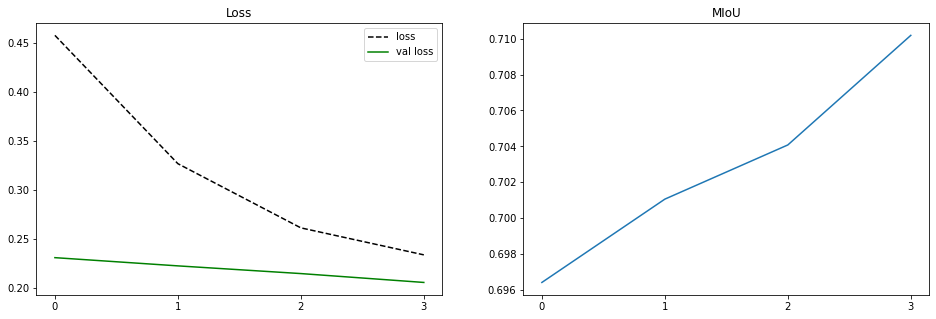

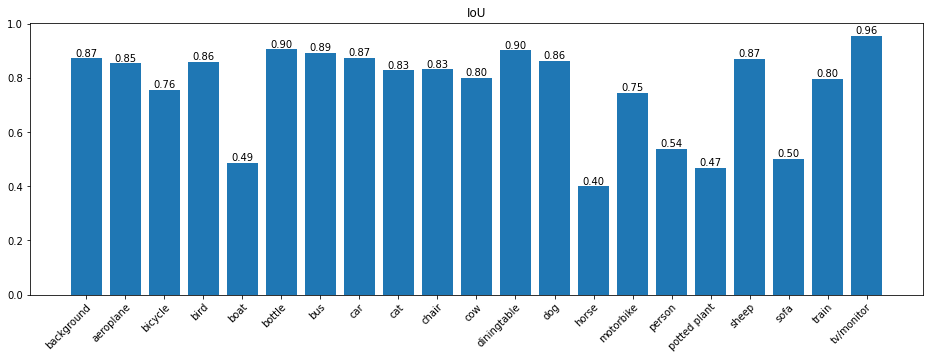

In [17]:
epochs = 4
hist = fit(net, train_loader, val_loader, epochs, crit, optimizer, **optimizer_args)
scores(hist)
logging.info(f'{hist["val_mean_miou"][-1]:.4f}')

In [18]:
iou = hist['val_iou']
miou = hist['val_miou']

Выбор 2 картинок на основе метрики MIoU из 3 квантилей по качеству: первые 10%, в промежутке между 15% - 25%, 45% - 55%.

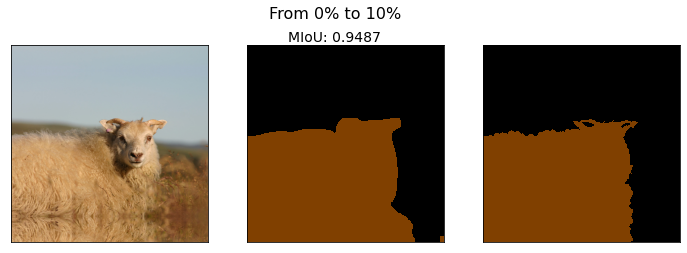

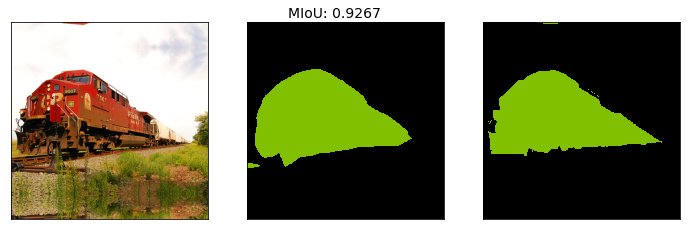

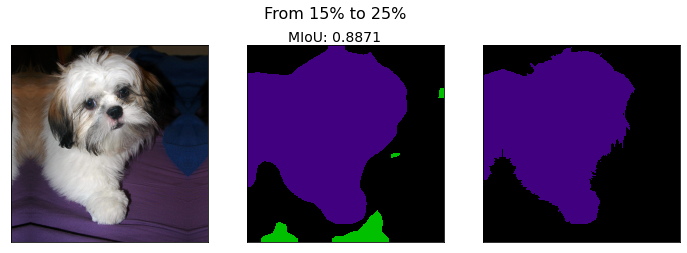

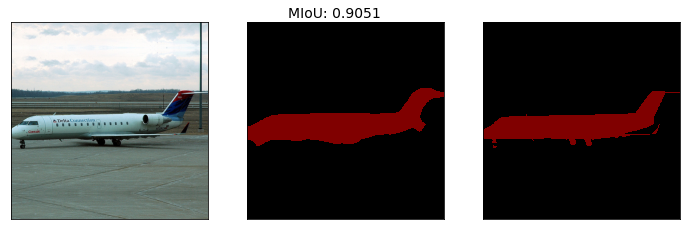

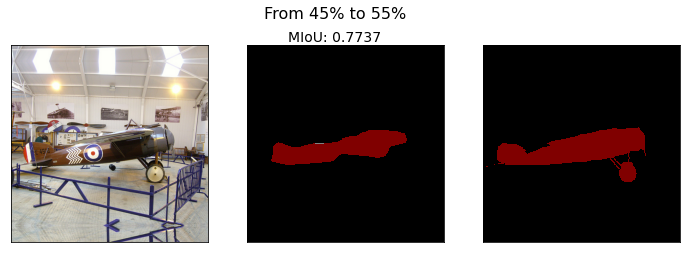

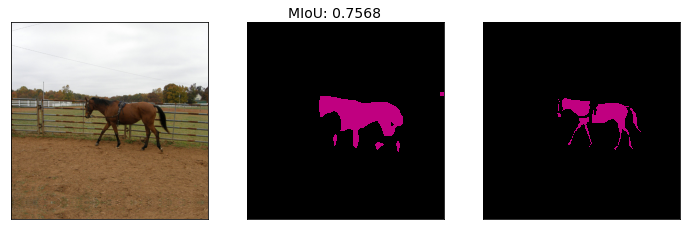

In [41]:
top_percent_images(net, val_dataset, miou, 0, 10)
print()
top_percent_images(net, val_dataset, miou, 15, 25)
print()
top_percent_images(net, val_dataset, miou, 45, 55)

Выбор лучшей по значению IoU картинки для трех классов.

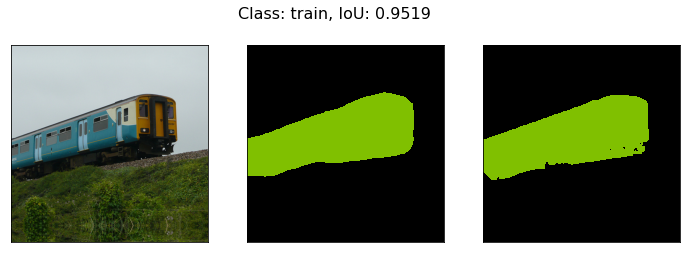

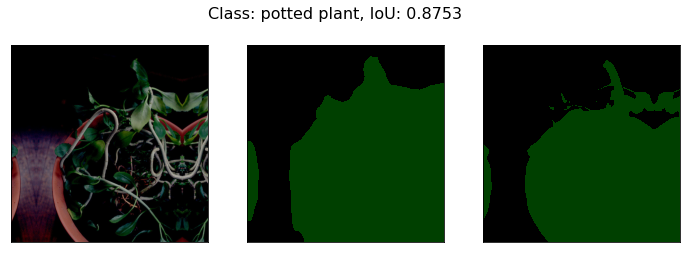

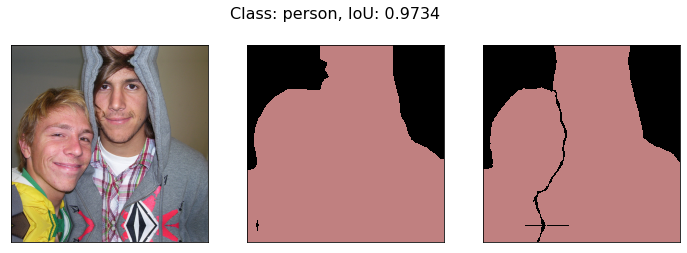

In [39]:
idx = np.random.choice(np.arange(1, len(VOC_CLASSES)), 3, replace=False)
for i in idx:
    top_class_image(net, val_dataset, iou, i)

Значения метрики IoU, усредненные по каждому классу для лучшей модели.

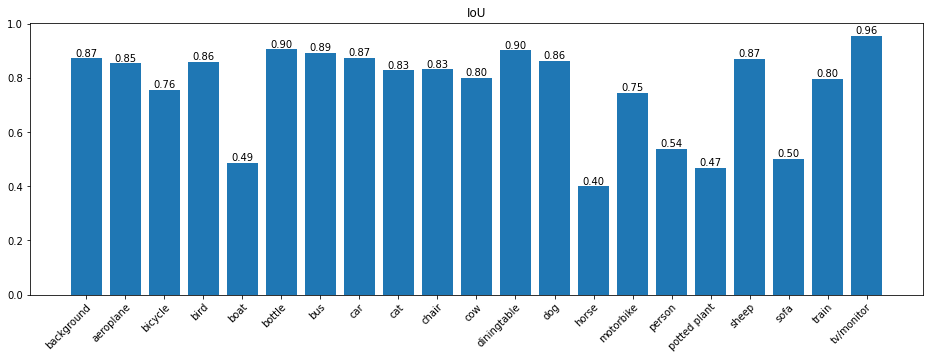

In [21]:
plot_class_mean_iou(iou)
plt.show()

История запусков. Резкий рост MIoU 1 декабря связан с тем, что IoU был все таки переписан с использованием битовых операций, вместо обычного сложения и умножения (таким образом при совпадении масок в объединении получается максимум 1, а не 2)

In [2]:
train_log = pd.read_csv('./train_log.csv', names=['DateTime', 'MIoU'])
train_log

,DateTime,MIoU
0,05-11-22 07:16:33,0.3713
1,05-11-22 07:59:15,0.3781
2,05-11-22 08:53:06,0.3746
3,07-11-22 14:04:21,0.3683
4,07-11-22 14:51:53,0.3749
5,07-11-22 15:28:49,0.3729
6,08-11-22 13:15:31,0.3729
7,08-11-22 14:06:02,0.3775
8,01-12-22 16:37:56,0.7585
9,01-12-22 18:10:40,0.7102
